# Set up Environment

In [30]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.19.0 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


In [31]:
# Make cluster by cluster plots
def plot_by_cluster(adata, clust_key, size=60, legend_loc=None, **kwargs):
    tmp = adata.copy()

    for i,clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype('category')
        tmp.uns[clust+'_colors'] = ['#d3d3d3', adata.uns[clust_key+'_colors'][i]]

    sc.pl.umap(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, legend_loc=legend_loc, **kwargs)

In [32]:
# Map annotations to abbreviated names
def annotation_abbr(annotations):
    tmp = []
    for ann in annotations:
        ann = ann.replace('Natural killer T (NKT) cell','NKT')
        ann = ann.replace('Hematopoietic stem cell','HSC')
        ann = ann.replace('Mesenchymal stem cell','MSC')
        ann = ann.replace('Natural killer cell','NK')
        ann = ann.replace('Embryonic stem cell','ESC')
        ann = ann.replace('Regulatory T (Treg) cell', 'Treg')
        ann = ann.replace(' (Th1)','')
        ann = ann.replace('T helper', 'Th')
        ann = ann.replace(' cell','')
        ann = ann.replace('-','UND')
        tmp.append(ann)
    return tmp

In [33]:
def names_make_unique(annotations):
    ann_dic = {}
    # construct dictionary for all names, cluster indices will be stored for each name
    for i,ann in enumerate(annotations):
        if ann_dic.get(ann)==None:
            ann_dic[ann] = [i]
        else:
            ann_dic[ann].append(i)
    #  
    for ann in ann_dic:
        num = len(ann_dic[ann])
        if num > 1:
            for indx in ann_dic[ann]:
                annotations[indx] = '('+ann+')'+'_'+ str(num)
                num -= 1
    return annotations

## Loading projection coordinates and cluster annotations

In [65]:
combined_umap = sc.read('/scratch/combined_umap.h5ad')

In [66]:
# copy and paste the raw output for umap
umap_annotation_output=[['0', '?', 'T cell|Natural killer cell', '6.416679890173055|4.89304737253182', 1.3113872402287532],
['1', '?', 'T helper cell|Natural killer T (NKT) cell', '2.341946701493572|2.341946701493572', 1.0],
['10', '?', 'T cell|Natural killer T (NKT) cell', '7.655209304317028|5.976039501816364', 1.2809837187304896],
['11', '?', 'T cell|Natural killer T (NKT) cell', '7.238051585998569|5.241639388660388', 1.380875533264872],
['12', '?', 'Natural killer T (NKT) cell|T helper1 (Th1) cell', '5.006032900780562|3.935275426406395', 1.2720921303726787],
['13', 'N', '-', '-', '-'],
['14', 'Good', 'Natural killer T (NKT) cell', 5.265686466214344, 3.1294782595519792],
['15', '?', 'Mesenchymal stem cell|Stem cell', '7.54646208935744|4.026965761474616', 1.873982183199401],
['16', 'Good', 'Basal cell', 8.867482137954381, 2.553588955029222],
['17', '?', 'Astrocyte|Natural killer T (NKT) cell', '4.141613418826587|3.517415083585177', 1.1774593900374097],
['18', '?', 'Endothelial cell|Mesenchymal stem cell', '9.64556042093968|5.360456989609257', 1.799391439878483],
['19', 'Good', 'B cell', 8.84050688389043, 5.1625351071671695],
['2', '?', 'T cell|Microglial cell', '5.059240312224758|4.611414862117644', 1.097112375159728],
['20', '?', 'Stem cell|Progenitor cell', '6.779790352526641|3.882361157659156', 1.7463059404330303],
['21', 'Good', 'Microglial cell', 5.135416013596932, 2.1410735353862838],
['22', '?', 'Mast cell|Hematopoietic stem cell', '7.309885502691608|4.553707079756475', 1.605260368017024],
['3', 'Good', 'B cell', 10.256068961540127, 8.10744121584214],
['4', 'Good', 'Microglial cell', 6.964909147741527, 3.6186682703023108],
['5', '?', 'Natural killer T (NKT) cell|T helper cell', '4.284032847755692|3.3618696145564093', 1.2743007132717015],
['6', 'Good', 'Goblet cell', 0.2670585925550672, '-'],
['7', 'Good', 'B cell', 8.906666436178881, 2.157634837243236],
['8', '?', 'Basal cell|Embryonic stem cell', '6.004783773653284|4.472904162441219', 1.3424798644413602],
['9', '?', 'Natural killer cell|Natural killer T (NKT) cell', '7.0462375280578815|4.431518315848034', 1.590027847308916]]

# extract annotations
umap_cluster_names = [None for _ in range(len(umap_annotation_output))]
for annotation in umap_annotation_output:
    index = int(annotation[0])
    name = annotation[2]
    umap_cluster_names[index] = name
    
umap_cluster_names = annotation_abbr(umap_cluster_names)
umap_cluster_names = names_make_unique(umap_cluster_names)

In [67]:
# View cluster annotations and get the number of labels that needs extra attention
for i,name in enumerate(umap_cluster_names):
    print((i,name))

(0, 'T|NK')
(1, 'Th|NKT')
(2, 'T|Microglial')
(3, '(B)_3')
(4, '(Microglial)_2')
(5, 'NKT|Th')
(6, 'Goblet')
(7, '(B)_2')
(8, 'Basal|ESC')
(9, 'NK|NKT')
(10, '(T|NKT)_2')
(11, '(T|NKT)_1')
(12, 'NKT|Th1')
(13, 'UND')
(14, 'NKT')
(15, 'MSC|Stem')
(16, 'Basal')
(17, 'Astrocyte|NKT')
(18, 'Endothelial|MSC')
(19, '(B)_1')
(20, 'Stem|Progenitor')
(21, '(Microglial)_1')
(22, 'Mast|HSC')


# Unannotated UMAP plot with Marker Genes

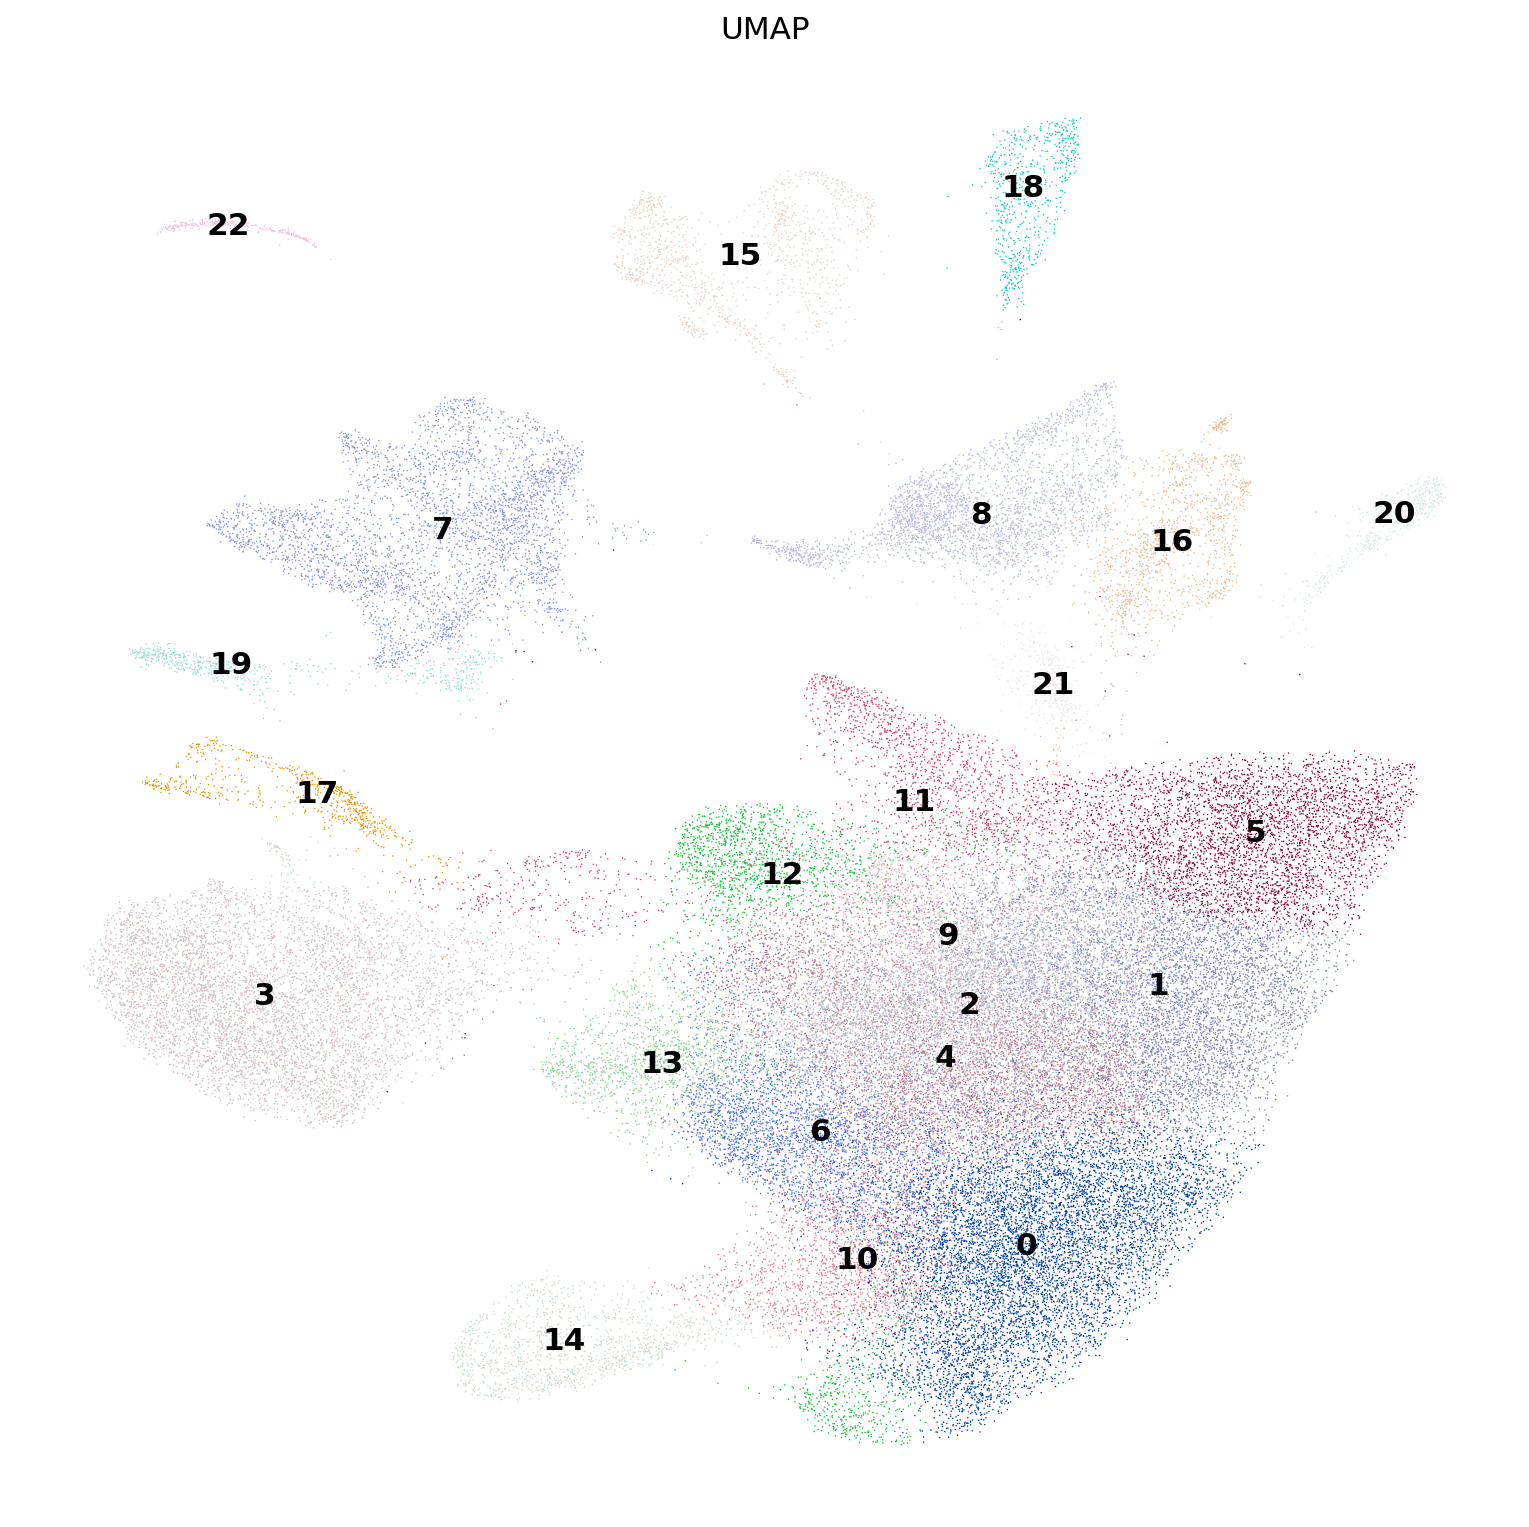

In [68]:
fig, ax = plt.subplots(figsize=(12,12))
sc.pl.umap(combined_umap, color='louvain', title='UMAP', legend_loc='on data',frameon=False,ax=ax)

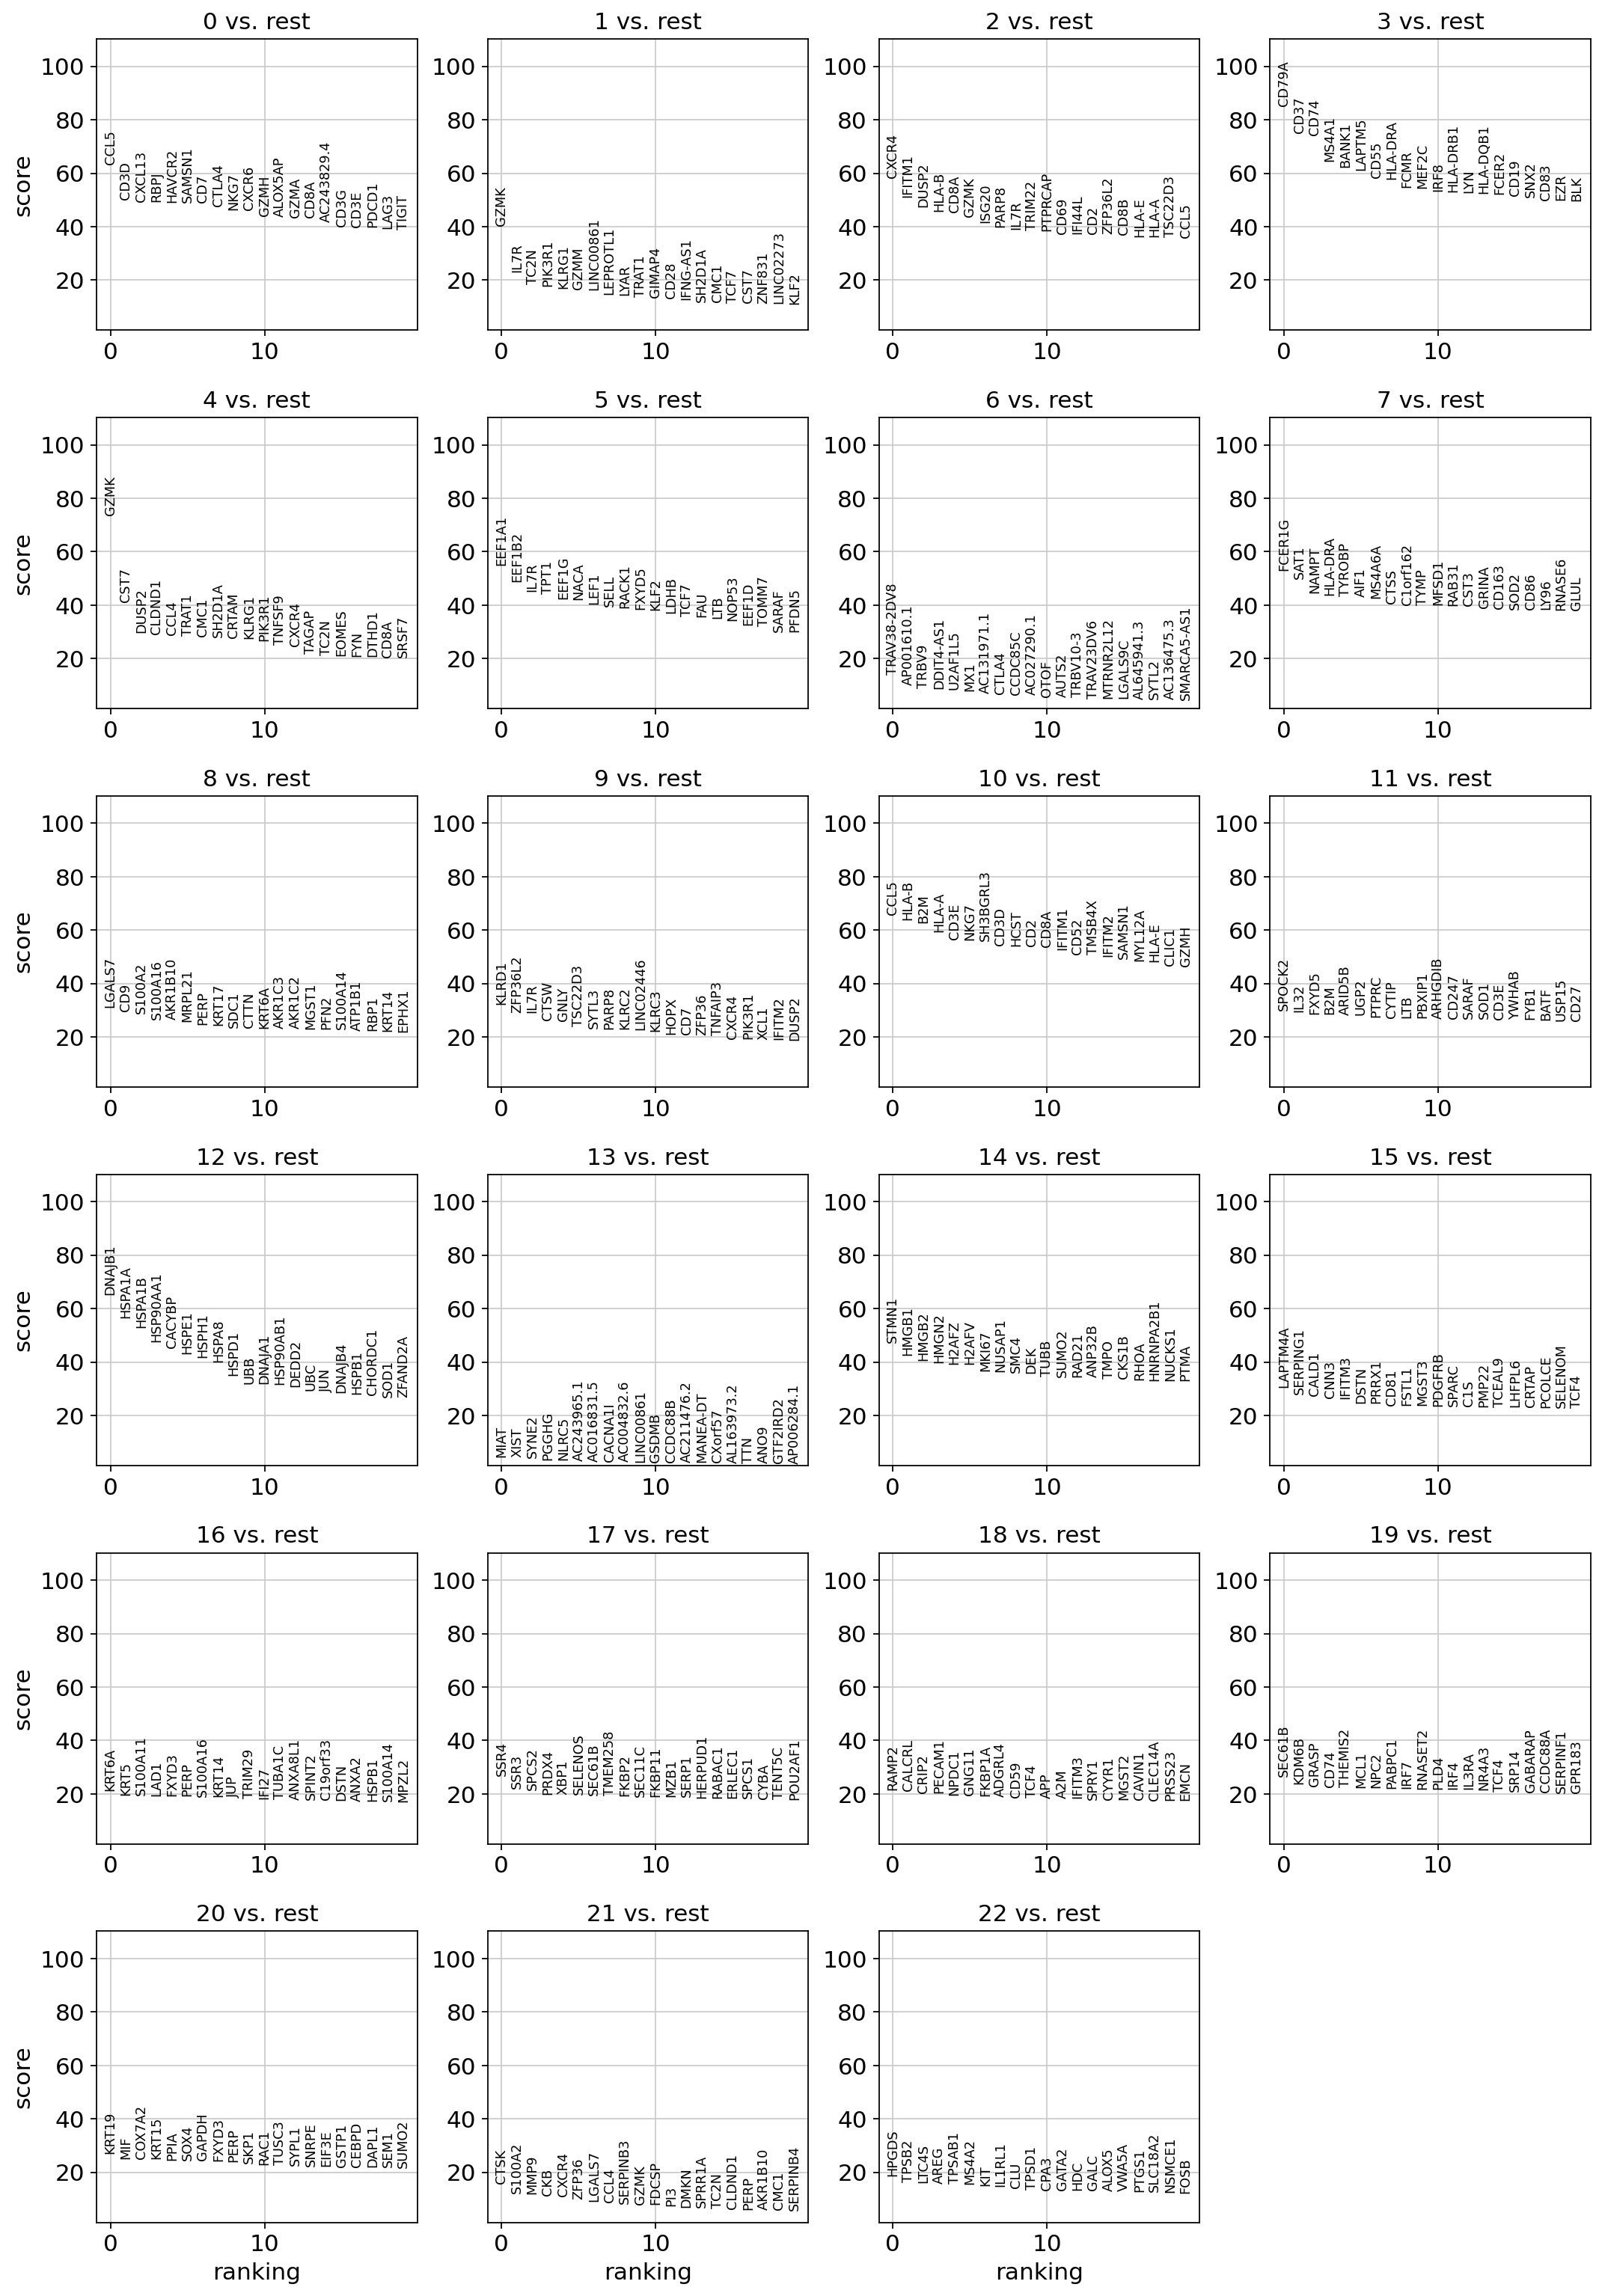

In [69]:
sc.pl.rank_genes_groups(combined_umap)

# Automatic Annotations on Clusters
#### Note that here the genes are selected based on gene score which leverages both adjusted p-value and log-fold-change. Since all the p-values for top 5 genes do not have any numerical significance (below machine limit), we don't list them here.

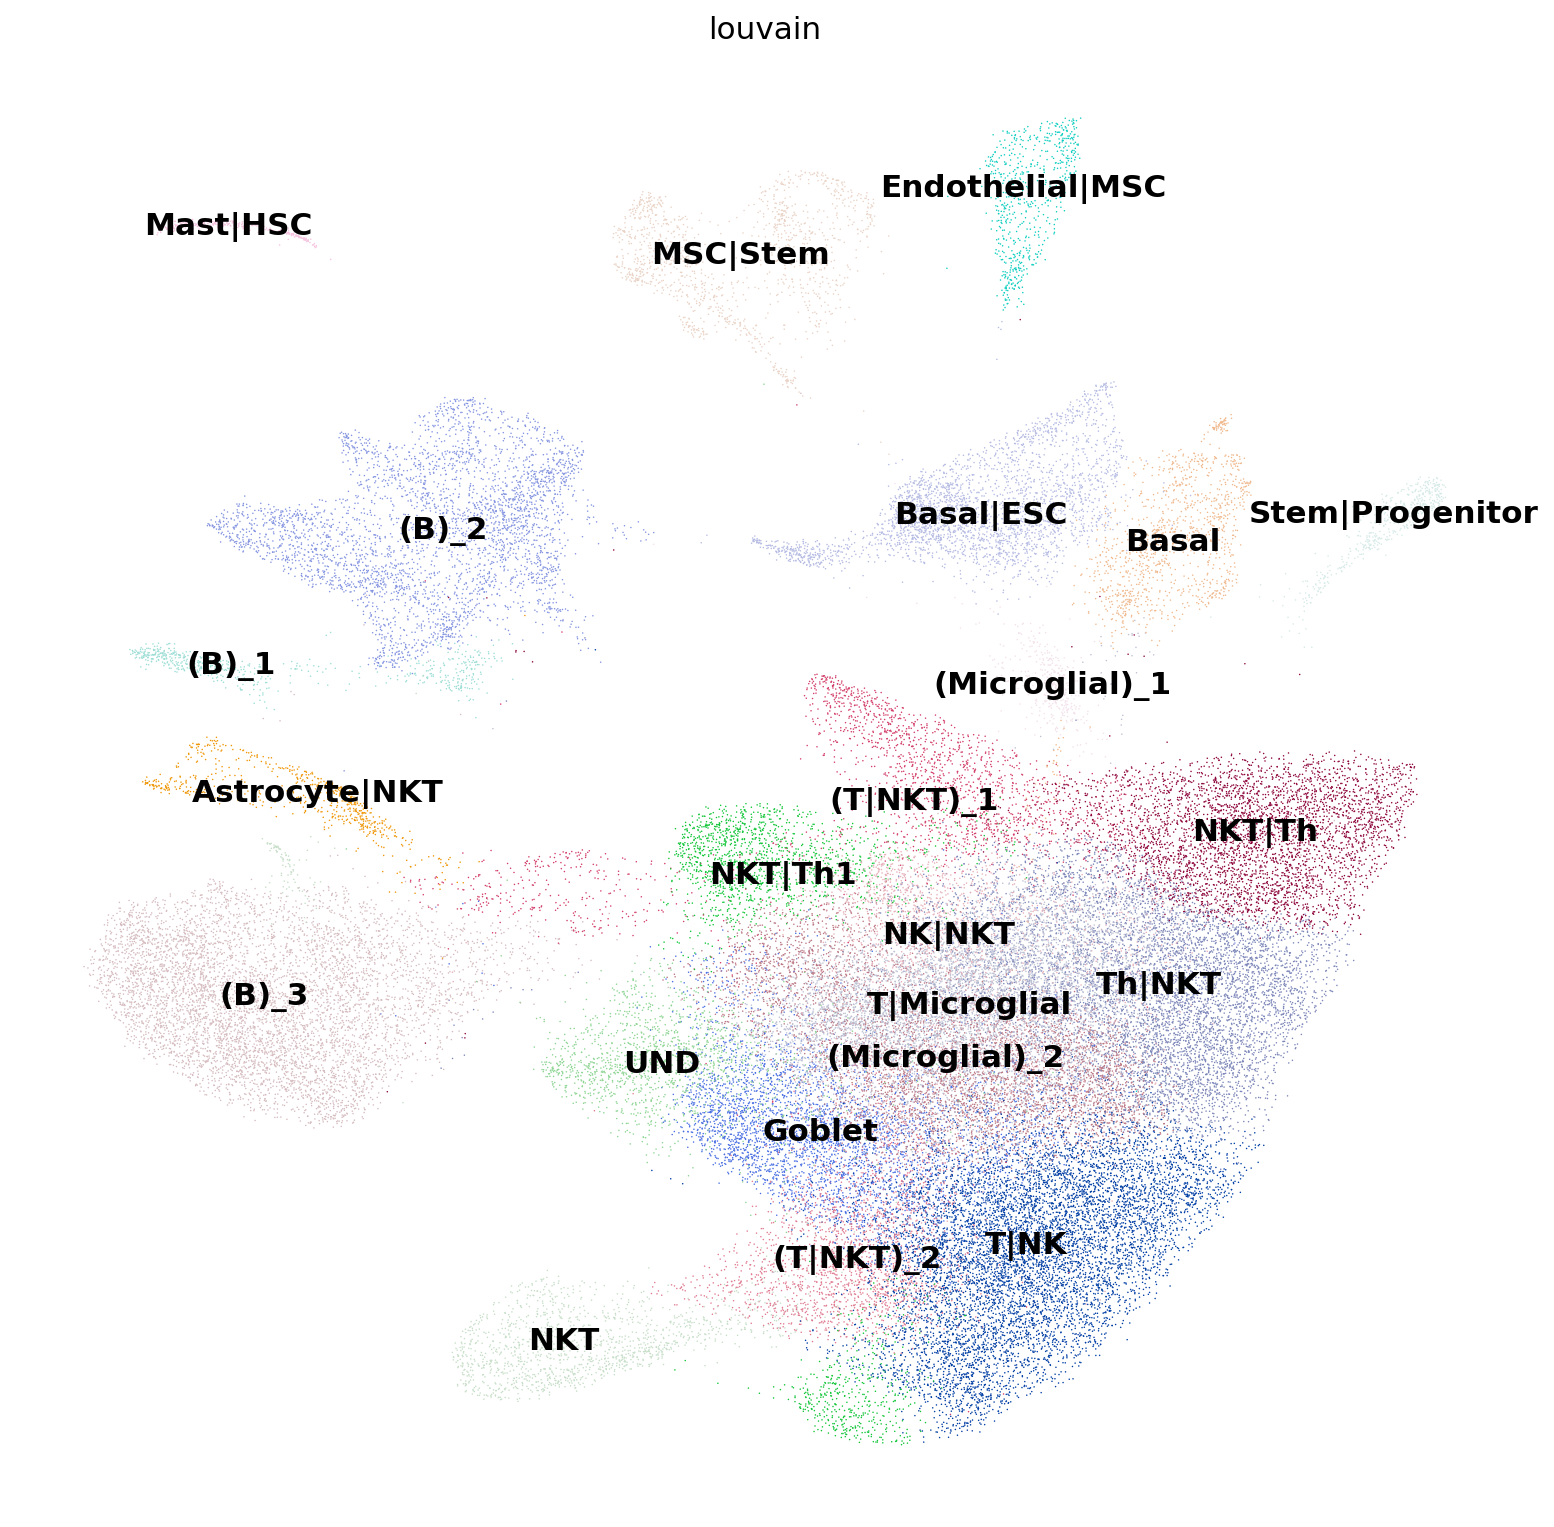

In [70]:
combined_umap.rename_categories('louvain', umap_cluster_names)
fig, ax = plt.subplots(figsize=(12,12))
sc.pl.umap(combined_umap, color='louvain',legend_loc='on data',frameon=False,ax=ax)

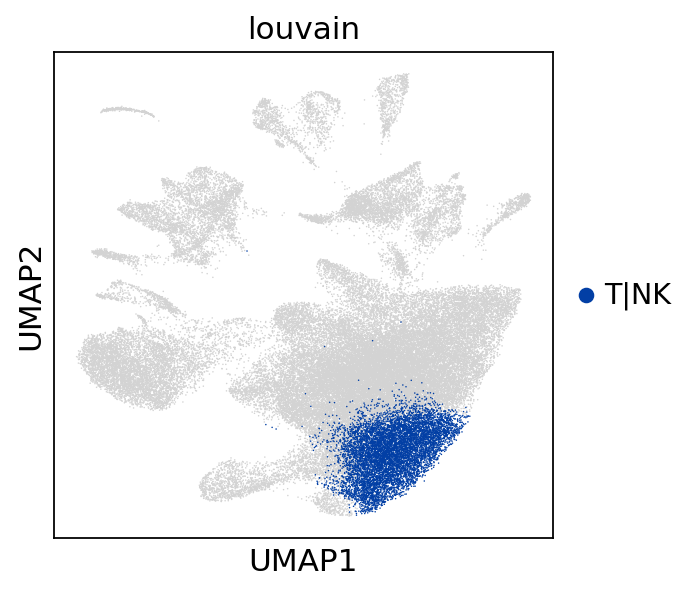

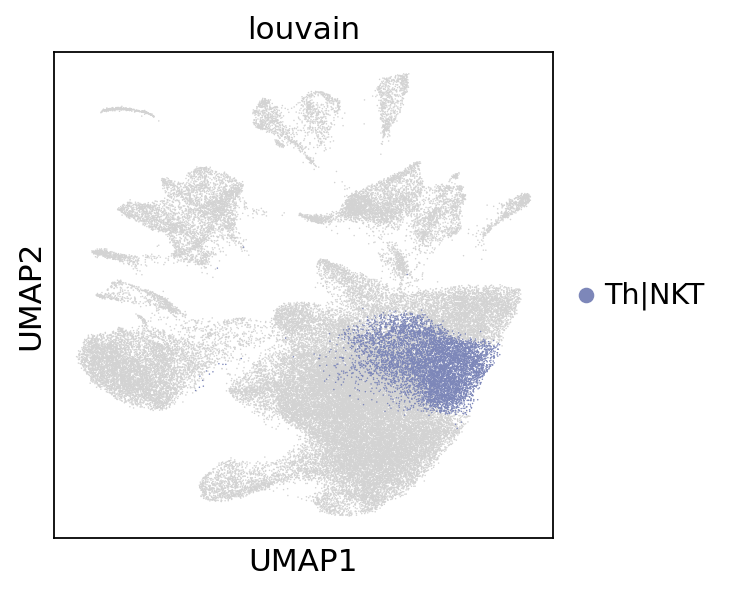

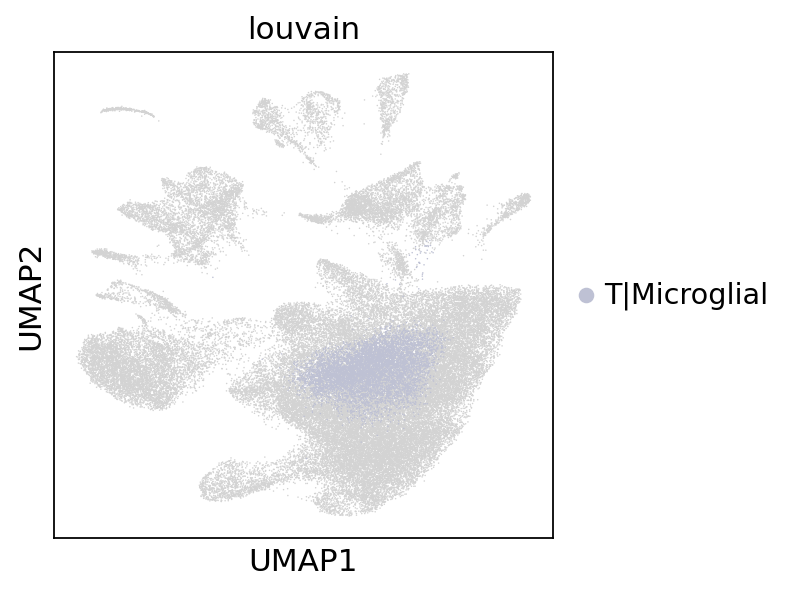

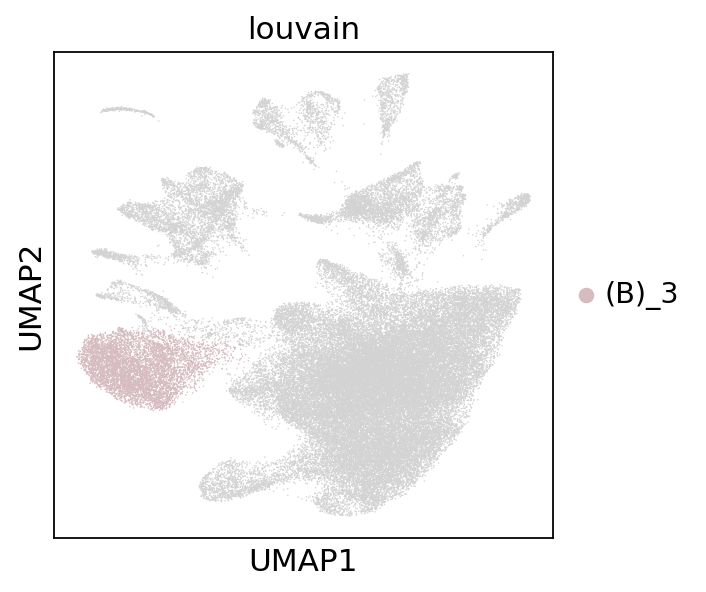

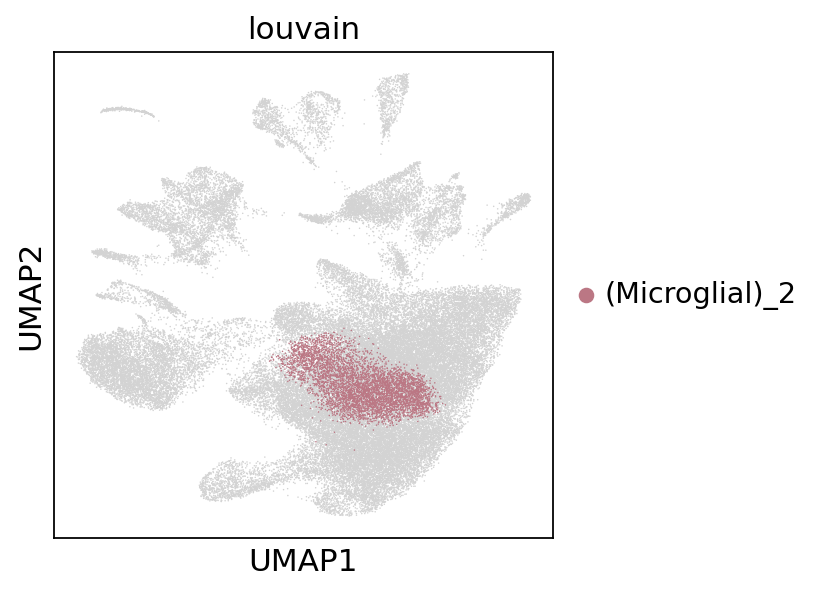

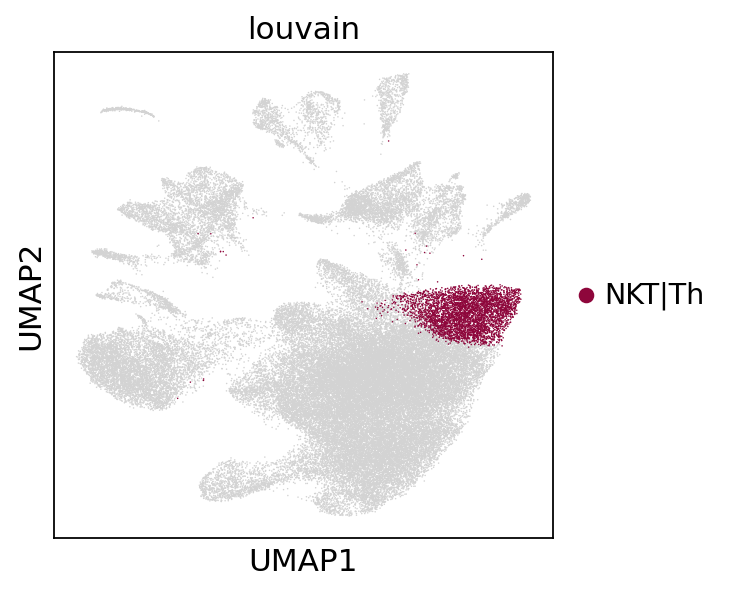

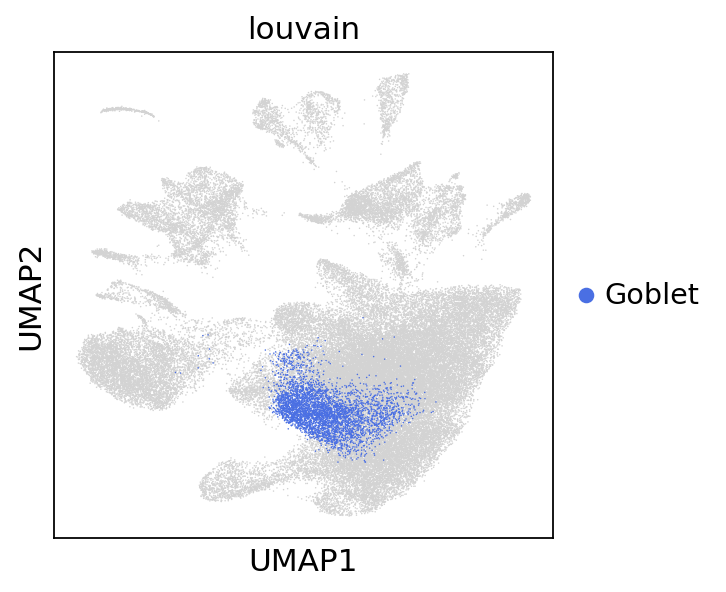

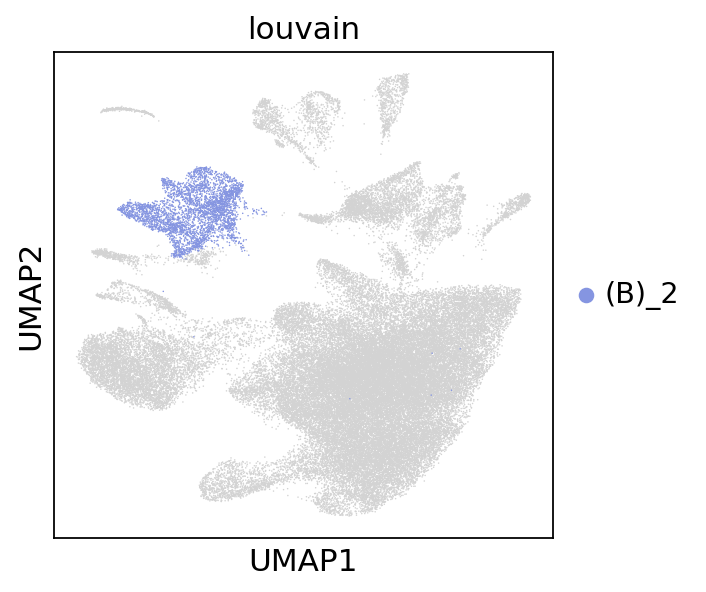

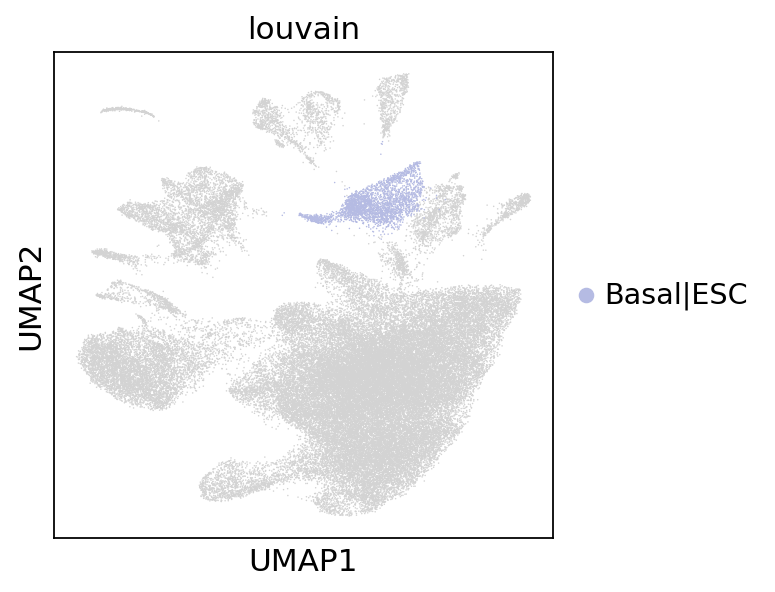

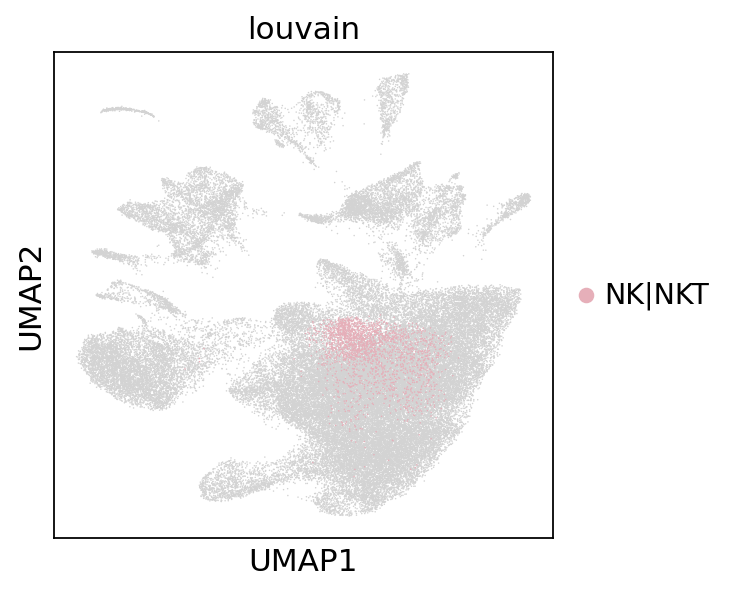

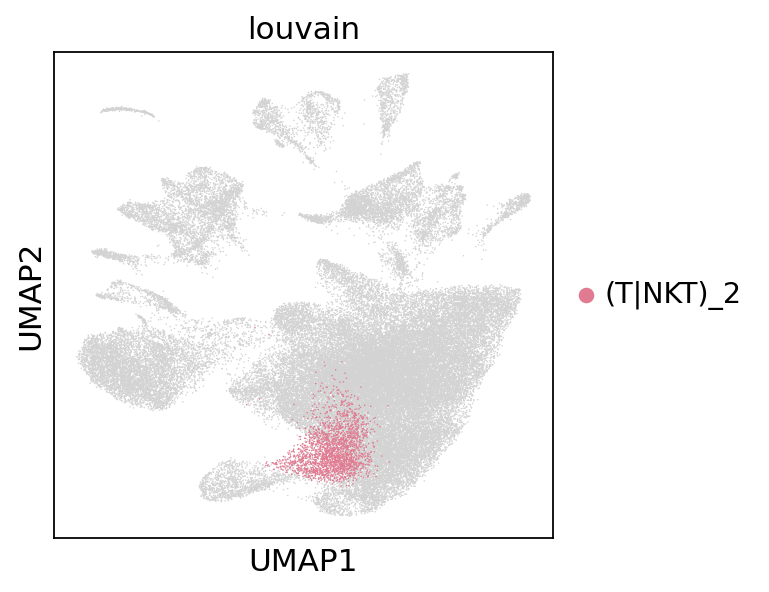

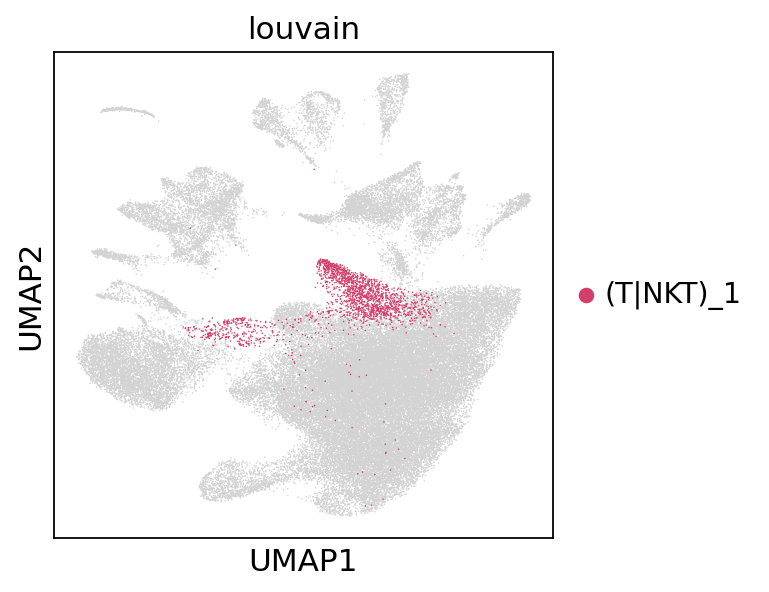

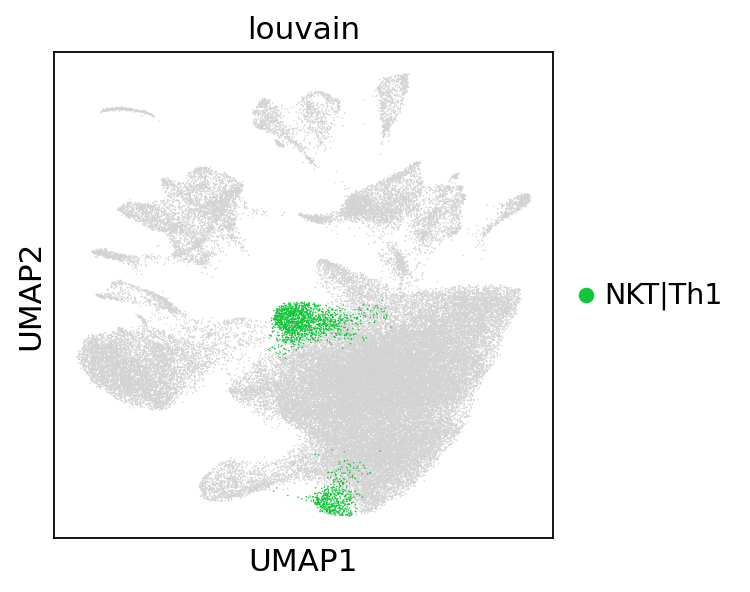

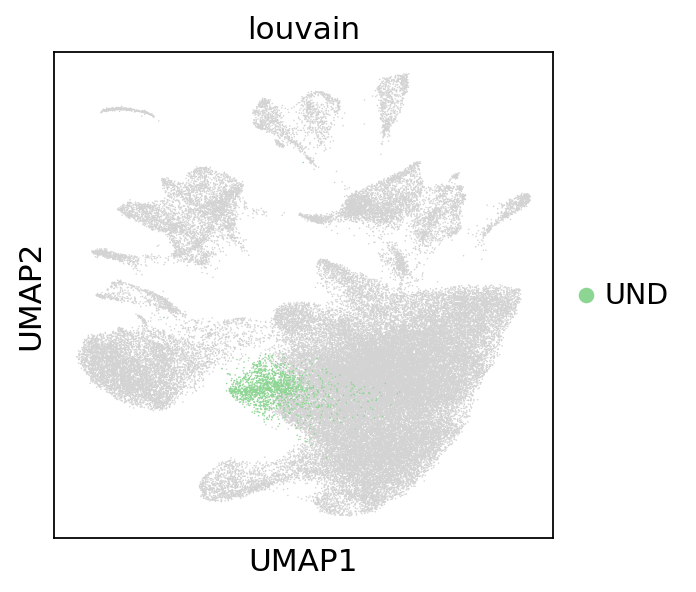

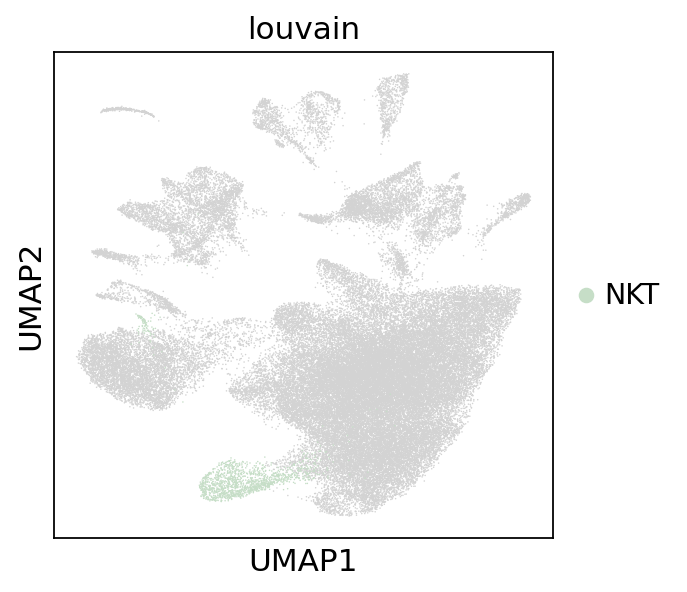

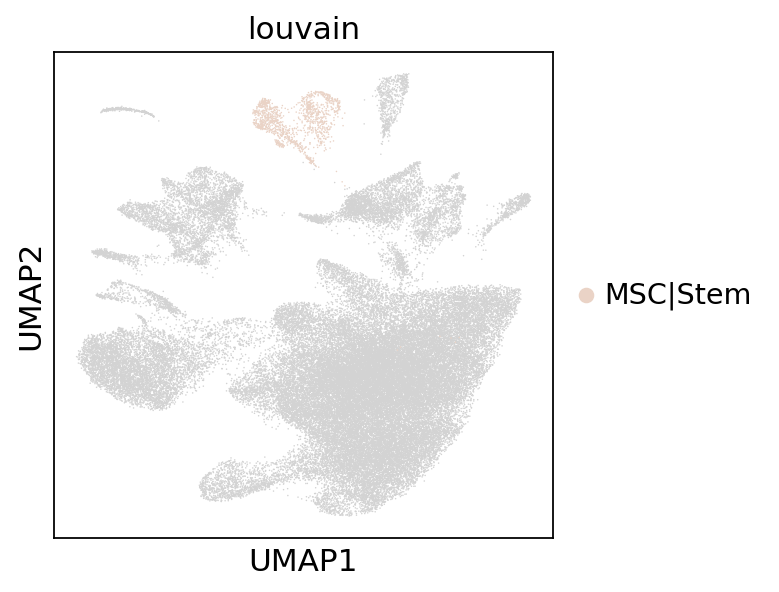

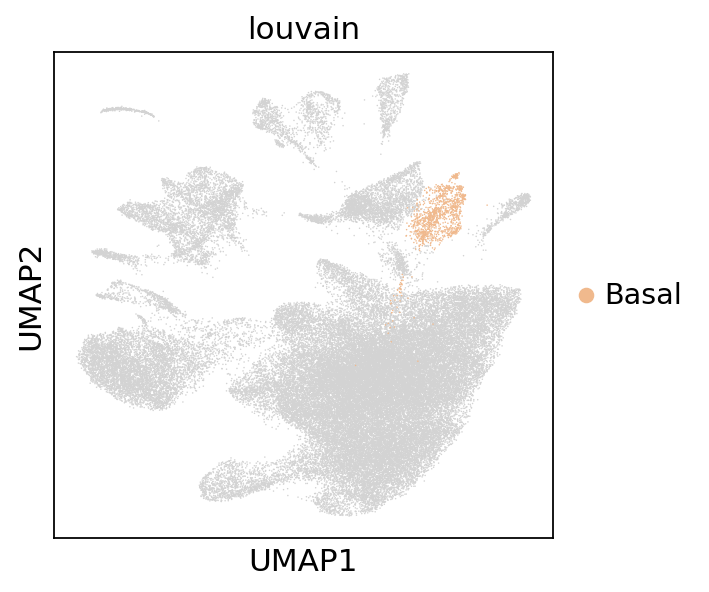

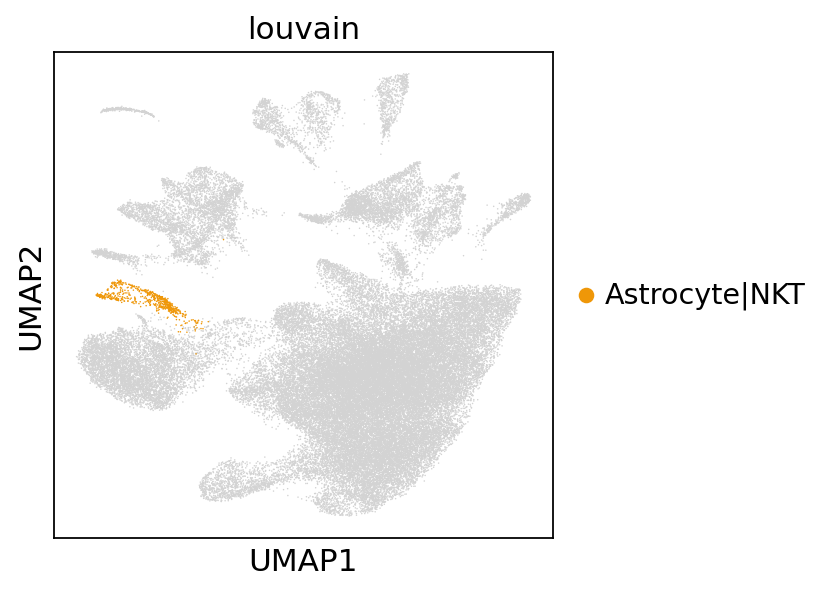

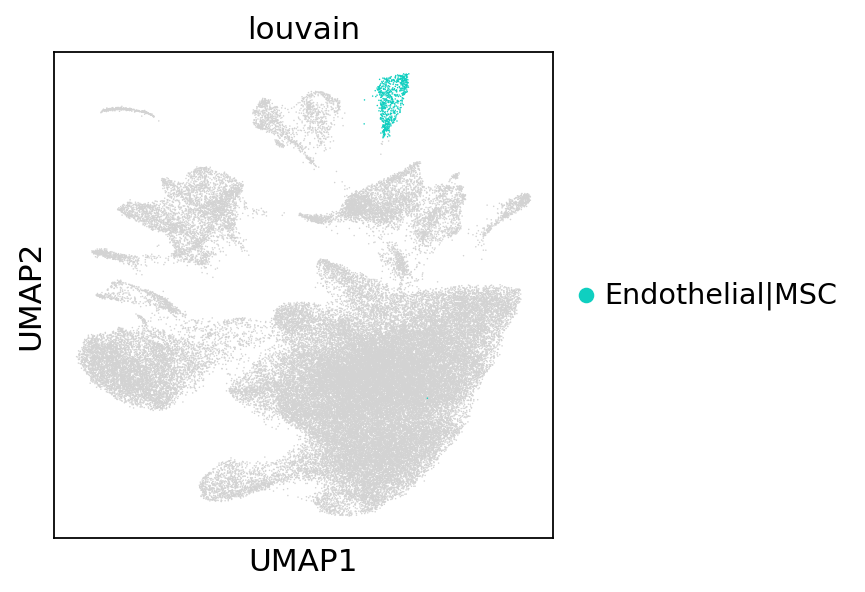

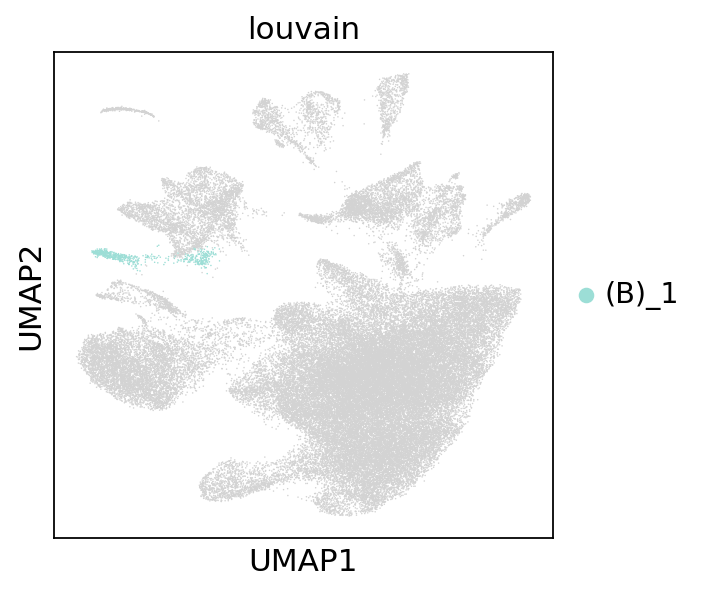

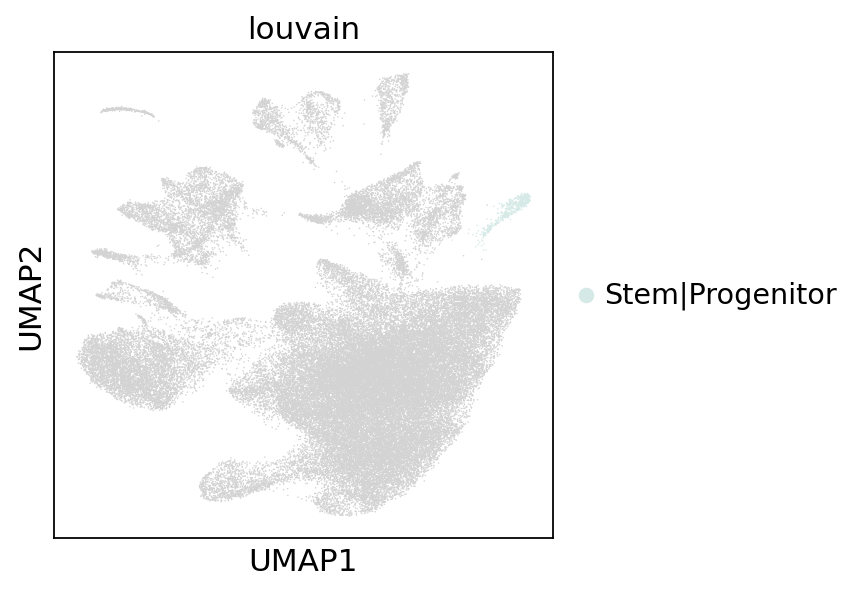

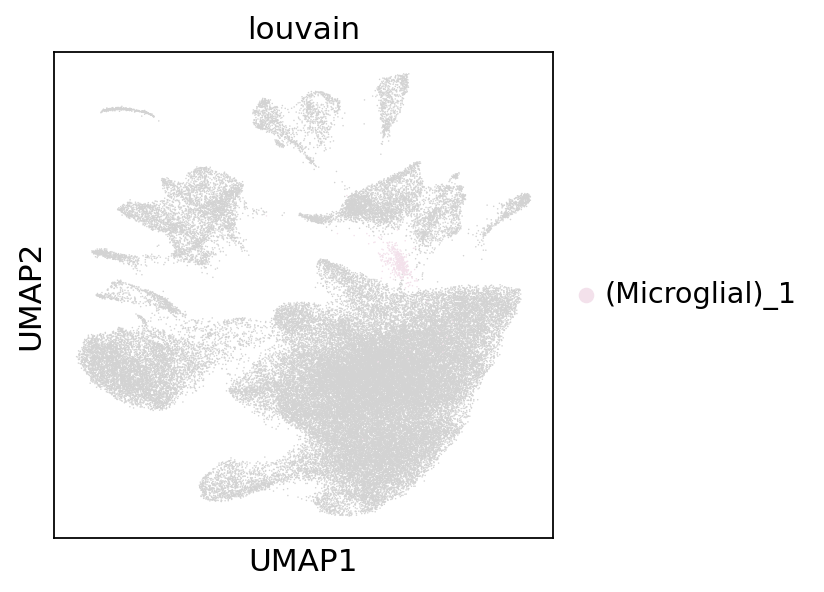

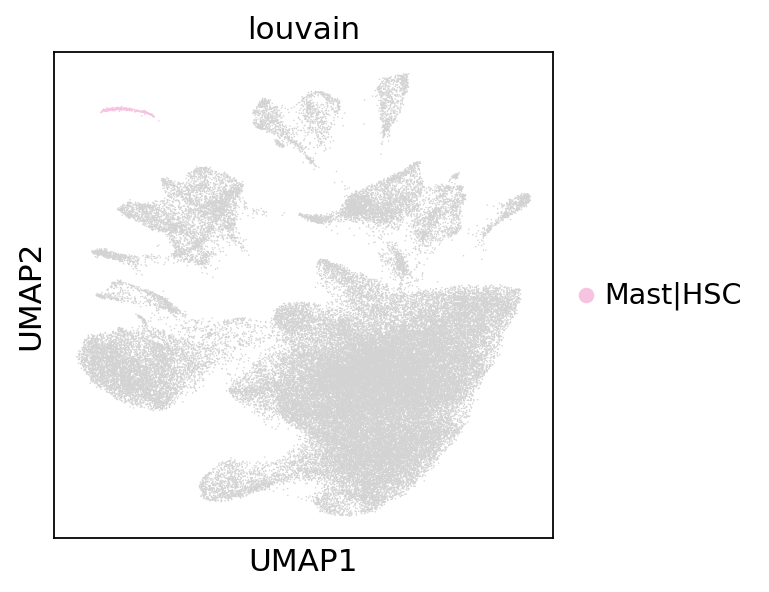

In [71]:
for cluster in umap_cluster_names:
    sc.pl.umap(combined_umap,color='louvain',groups=[cluster])